In [2]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf

import matplotlib.pyplot as plt

In [3]:
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=url,
                                   fname="flower_photos.tgz",
                                   untar=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228813984/228813984 [==============================] - 10s 0us/step


In [ ]:
base_dir

'/root/.keras/datasets/flower_photos'

In [4]:
BATCH_SIZE = 100
IMG_SHAPE = 150

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(base_dir, validation_split=0.2, subset="training", 
                                                       seed=27, image_size=(IMG_SHAPE, IMG_SHAPE),
                                                       batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(base_dir, validation_split=0.2, subset="validation",
                                                     seed=27, image_size=(IMG_SHAPE, IMG_SHAPE),
                                                     batch_size=BATCH_SIZE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(100, 150, 150, 3)
(100,)


In [6]:
classes = train_ds.class_names
print(classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [8]:
augment = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.5),
    tf.keras.layers.RandomWidth(0.15),
    tf.keras.layers.RandomHeight(0.15),
    tf.keras.layers.Resizing(IMG_SHAPE, IMG_SHAPE)
])

In [ ]:
for images, labels in train_ds.take(1):
  images = images
print(images[0])

tf.Tensor(
[[[224.83333  212.83333  172.5     ]
  [214.695    203.695    158.      ]
  [192.76833  172.26834  101.101685]
  ...
  [202.61     173.61     167.61    ]
  [203.5      175.       165.5     ]
  [203.       174.39     165.42336 ]]

 [[227.33     213.38667  174.35834 ]
  [212.67     203.5      160.33    ]
  [191.44667  173.33     104.82335 ]
  ...
  [204.       175.       169.      ]
  [203.5      174.5      167.33    ]
  [203.17     175.       171.      ]]

 [[226.45833  212.875    173.66667 ]
  [214.025    205.025    162.025   ]
  [191.90834  178.075    115.51668 ]
  ...
  [203.88335  175.21666  168.95    ]
  [203.       176.       169.      ]
  [203.05833  175.95833  169.00833 ]]

 ...

 [[ 94.975006  67.975006  74.65833 ]
  [ 88.5       63.5       66.54999 ]
  [ 84.6166    62.158253  72.69995 ]
  ...
  [143.04999   97.63336   79.07501 ]
  [141.475     96.975006  72.975006]
  [139.99167   94.99167   74.07498 ]]

 [[ 94.36167   67.713295  70.90495 ]
  [ 85.690094  62.850067  

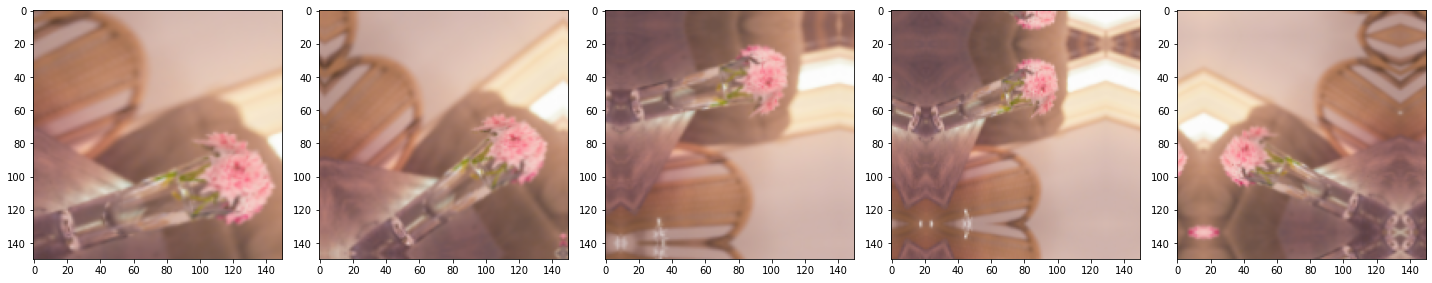

In [ ]:
augmented_images = [augment(images[0]) for i in range(5)]
plotImages(augmented_images)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
model = tf.keras.Sequential([
    augment,
    tf.keras.layers.Conv2D(16, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax),
])

In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [12]:
num_train = 2936
num_valid = 734

In [13]:
history = model.fit(train_ds, epochs=80, steps_per_epoch=int(np.ceil(num_train/float(BATCH_SIZE))),
                    validation_data=val_ds, validation_steps=int(np.ceil(num_valid/float(BATCH_SIZE))))

Epoch 1/80
30/30 [==============================] - 19s 225ms/step - loss: 1.5896 - accuracy: 0.3423 - val_loss: 1.2391 - val_accuracy: 0.4550
Epoch 2/80
30/30 [==============================] - 4s 119ms/step - loss: 1.1808 - accuracy: 0.5140 - val_loss: 1.1099 - val_accuracy: 0.5586
Epoch 3/80
30/30 [==============================] - 3s 105ms/step - loss: 1.0876 - accuracy: 0.5630 - val_loss: 1.1300 - val_accuracy: 0.5436
Epoch 4/80
30/30 [==============================] - 3s 95ms/step - loss: 1.0365 - accuracy: 0.6025 - val_loss: 1.1161 - val_accuracy: 0.5654
Epoch 5/80
30/30 [==============================] - 3s 96ms/step - loss: 0.9904 - accuracy: 0.6066 - val_loss: 1.2340 - val_accuracy: 0.5232
Epoch 6/80
30/30 [==============================] - 3s 96ms/step - loss: 0.9633 - accuracy: 0.6250 - val_loss: 1.0291 - val_accuracy: 0.5981
Epoch 7/80
30/30 [==============================] - 3s 98ms/step - loss: 0.9129 - accuracy: 0.6512 - val_loss: 1.0699 - val_accuracy: 0.6035
Epoch 8/8

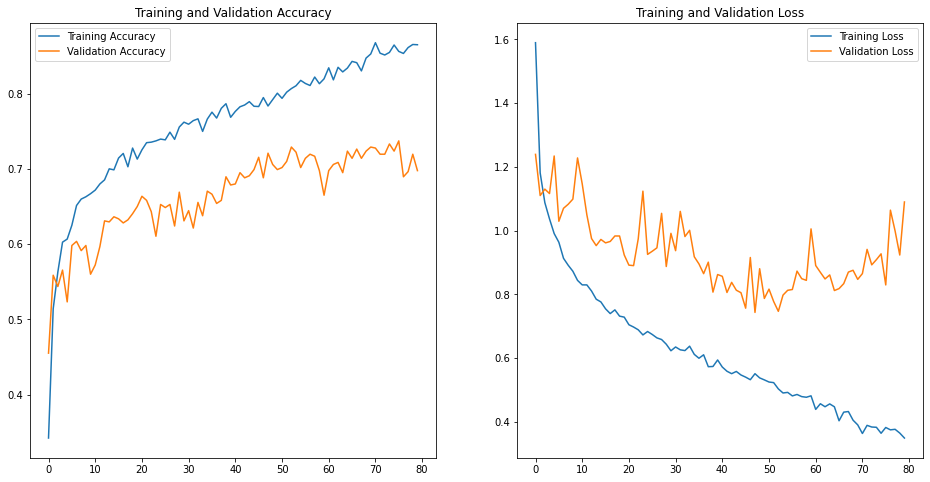

In [19]:
epoch_range = range(80)

acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.plot(epoch_range, acc, label='Training Accuracy')
ax1.plot(epoch_range, val_acc, label='Validation Accuracy')
ax1.legend(loc='upper left')
ax1.set_title('Training and Validation Accuracy')

ax2.plot(epoch_range, loss, label='Training Loss')
ax2.plot(epoch_range, val_loss, label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_title('Training and Validation Loss')

plt.show()